In [123]:
import pandas as pd
import numpy as np
import json
import ast
from tqdm import tqdm
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt
from neo4j import GraphDatabase, basic_auth
from dotenv import load_dotenv
import random


In [97]:
def jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    intersection = len(set1.intersection(set2))
    union = len(set1) + len(set2) - intersection    
    if union == 0:
        return 0.0
    else:
        jaccard_similarity = intersection / union
        return jaccard_similarity
    
def extract_answer(text):
    pattern = r'{[^{}]*}'
    match = re.search(pattern, text)
    if match:
        return match.group()
    else:
        return None
    
def extract_by_splitting(text):
    compound_list = text.split(':')[1].split("Diseases")[0].split("], ")[0]+"]"
    disease_list = text.split(':')[-1].split("}")[0]
    resp = {}
    resp["Compounds"] = ast.literal_eval(compound_list)
    resp["Diseases"] = ast.literal_eval(disease_list)
    return resp
    

In [156]:
DATA_PATH = "../../../data/analysis_results/gpt_4_node_retrieval_rag_based_drug_reporposing_questions.csv"


In [157]:
data = pd.read_csv(DATA_PATH)


## Compute the performance of KG-RAG based LLM on drug repurposing

In [158]:
%%time

llm_performance_list = []
for index, row in tqdm(data.iterrows()):
    cmp_gt = ast.literal_eval(row["compound_groundTruth"])
    disease_gt = ast.literal_eval(row["disease_groundTruth"])
    try:
        llm_answer = json.loads(extract_answer(row["llm_answer"]))
    except:
        llm_answer = extract_by_splitting(row["llm_answer"])
    cmp_llm = llm_answer["Compounds"]
    disease_llm = llm_answer["Diseases"]
    cmp_similarity = jaccard_similarity(cmp_gt, cmp_llm)
    disease_similarity = jaccard_similarity(disease_gt, disease_llm)
    llm_performance = np.mean([cmp_similarity, disease_similarity])
    llm_performance_list.append(llm_performance)


143it [00:00, 4367.60it/s]

CPU times: user 34 ms, sys: 2.92 ms, total: 36.9 ms
Wall time: 36.2 ms


## Extract all disease nodes from SPOKE for baseline distribution computation 

In [120]:
%%time


load_dotenv(os.path.join(os.path.expanduser('~'), '.neo4j_config.env'))
USER = os.environ.get('SPOKE_USER')
PSW = os.environ.get('SPOKE_PSW')
URI = os.environ.get('SPOKE_URI')

DISEASE_QUERY = """
    MATCH(d:Disease) 
    RETURN DISTINCT d.name AS d_name     
"""

COMPOUND_QUERY = """
    MATCH(c:Compound) 
    RETURN DISTINCT c.name AS c_name     
"""


auth = basic_auth(USER, PSW)
sdb = GraphDatabase.driver(URI, auth=auth)

disease_list = []
with sdb.session() as session:
    with session.begin_transaction() as tx:
        result = tx.run(DISEASE_QUERY)
        for row in result:
            disease_list.append(row["d_name"])
            
compound_list = []
with sdb.session() as session:
    with session.begin_transaction() as tx:
        result = tx.run(COMPOUND_QUERY)
        for row in result:
            compound_list.append(row["c_name"])
                        
sdb.close()


CPU times: user 54.6 s, sys: 8.34 s, total: 1min 2s
Wall time: 2min 52s


## Compute the baseline distribution for drug repurposing
### Base line distriubtion gives the performance metric (ie. Jaccard similarity between ground truth and prediction) on randomly selected Compound and Disease nodes

In [159]:
%%time

niter = 10000

llm_performance_baseline_list = []
for index, row in tqdm(data.iterrows()):
    cmp_gt = ast.literal_eval(row["compound_groundTruth"])
    disease_gt = ast.literal_eval(row["disease_groundTruth"])
    try:
        llm_answer = json.loads(extract_answer(row["llm_answer"]))
    except:
        llm_answer = extract_by_splitting(row["llm_answer"])
    cmp_llm = llm_answer["Compounds"]
    disease_llm = llm_answer["Diseases"]
    cmp_similarity = 0
    disease_similarity = 0
    if len(cmp_llm) > 0:
        cmp_similarity_list = []
        for i in range(niter):
            cmp_llm_random = random.sample(compound_list, len(cmp_llm))
            cmp_similarity_list.append(jaccard_similarity(cmp_gt, cmp_llm_random))
    if len(disease_llm) > 0:
        disease_similarity_list = []
        for i in range(niter):
            disease_llm_random = random.sample(disease_list, len(disease_llm))
            disease_similarity_list.append(jaccard_similarity(disease_gt, disease_llm_random))
    llm_performance_baseline = np.mean([np.mean(cmp_similarity_list), np.mean(disease_similarity_list)])
    llm_performance_baseline_list.append(llm_performance_baseline)


143it [00:17,  8.37it/s]

CPU times: user 17 s, sys: 132 ms, total: 17.1 s
Wall time: 17.1 s


## Plot Baseline vs KG-RAG performance

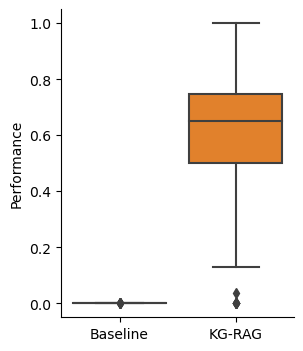

In [164]:
labels = ['Baseline', 'Performance']

data_to_plot = pd.DataFrame({'Group': ['Baseline'] * len(llm_performance_baseline_list) + ['KG-RAG'] * len(llm_performance_list),
                     'Performance': llm_performance_baseline_list + llm_performance_list})

# Create the box plot
plt.figure(figsize=(3, 4))
sns.boxplot(x='Group', y='Performance', data=data_to_plot)
sns.despine(top=True, right=True)
plt.xlabel('')
plt.ylabel('Performance')
plt.show()

figure_folder_name = "drug_repurposing"
fig_filename = "../../../data/analysis_results/figures/{}/drug_repurposing_performace_gpt_4_at_80_threshold.svg".format(figure_folder_name)
fig.savefig(fig_filename, format='svg', bbox_inches='tight')


## Effect of context similarity threshold parameter on KG-RAG performance


In [166]:
PARAMETER_FILES = [
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_10_threshold.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_20_threshold.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_30_threshold.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_40_threshold.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_50_threshold.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_60_threshold.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_70_threshold.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_90_threshold.csv"
]
PARAMETER_LIST = [10, 20, 30, 40, 50, 60, 70, 80, 90]

PARENT_PATH = "../../../data/analysis_results/"



In [172]:
param_perf_dict = {}
for file_index, item in tqdm(enumerate(PARAMETER_FILES)):
    data_selected = pd.read_csv(os.path.join(PARENT_PATH, item))
    llm_performance_list = []
    for index, row in data_selected.iterrows():
        cmp_gt = ast.literal_eval(row["compound_groundTruth"])
        disease_gt = ast.literal_eval(row["disease_groundTruth"])
        try:
            llm_answer = json.loads(extract_answer(row["llm_answer"]))
        except:
            llm_answer = extract_by_splitting(row["llm_answer"])
        cmp_llm = llm_answer["Compounds"]
        disease_llm = llm_answer["Diseases"]
        cmp_similarity = jaccard_similarity(cmp_gt, cmp_llm)
        disease_similarity = jaccard_similarity(disease_gt, disease_llm)
        llm_performance = np.mean([cmp_similarity, disease_similarity])
        llm_performance_list.append(llm_performance)
    param_perf_dict[PARAMETER_LIST[file_index]] = llm_performance_list

9it [00:00, 52.68it/s]


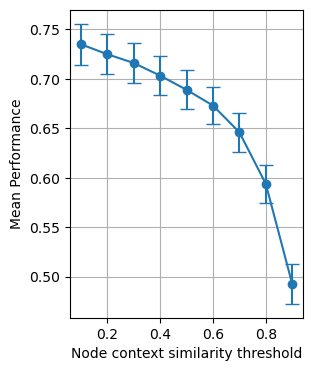

In [185]:
from scipy.stats import sem

params = list(param_perf_dict.keys())
performance_lists = list(param_perf_dict.values())
params = [param / 100 for param in params]

mean_performance = [np.mean(lst) for lst in performance_lists]
std_deviation = [np.std(lst) for lst in performance_lists]
sem_performance = [sem(lst) for lst in performance_lists]

plt.figure(figsize=(3, 4))
plt.errorbar(params, mean_performance, yerr=sem_performance, fmt='o-', capsize=5, label='Performance')

plt.xlabel('Node context similarity threshold')
plt.ylabel('Mean Performance')
# plt.title('Mean Performance with Error Bars')
# plt.legend()
plt.grid(True)

# Show the plot
plt.show()